In [2]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

In [4]:
import smart
import coronagraph as cg
import pandas as pd

In [6]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Exploratory Developement

In [8]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

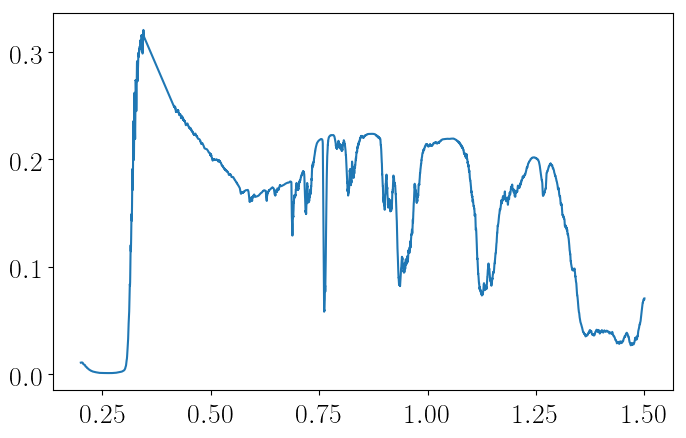

In [10]:
lammin = 0.2
lammax = 1.5
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m])

In [152]:
telescope = cg.Telescope(lammin = 0.4, 
                         lammax = 1.4, 
                         R = 140, 
                         Tput = 0.1, 
                         D = 16.
                        )

planet = cg.Planet(d = 5.0, 
                   Rp = 1.0, 
                   a = 1.0, 
                   alpha = 90.0
                  )

star = cg.Star(Teff = 5780., 
               Rs = 1.0
              )

In [24]:
cn = cg.CoronagraphNoise(telescope = telescope, 
                         planet = planet, 
                         star = star, 
                         THERMAL=True)

In [25]:
cn.run_count_rates(Ahr, lamhr, fstar)

In [26]:
cn.make_fake_data(texp = 10)

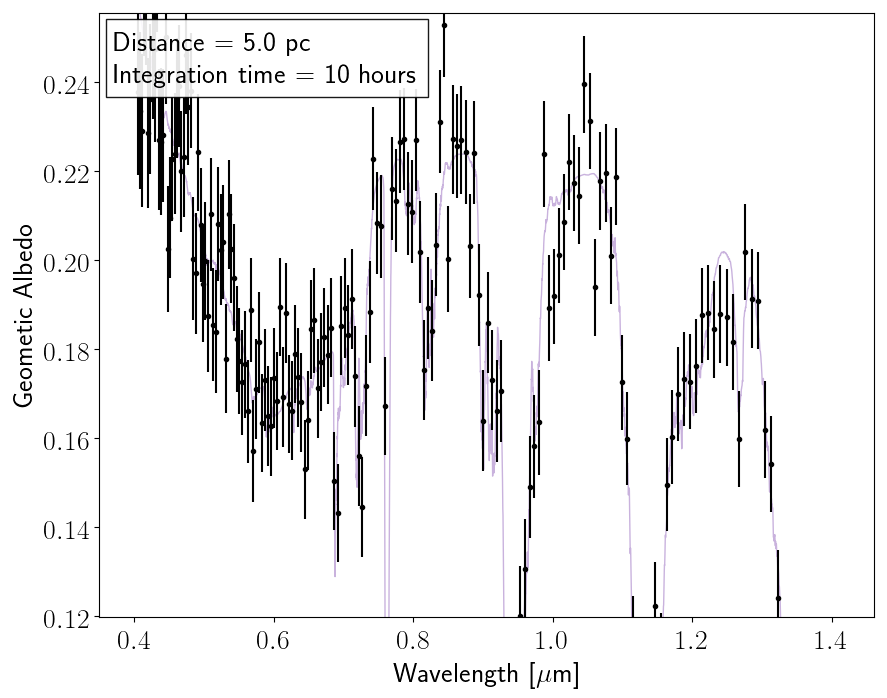

In [27]:
fig, ax = cn.plot_spectrum()

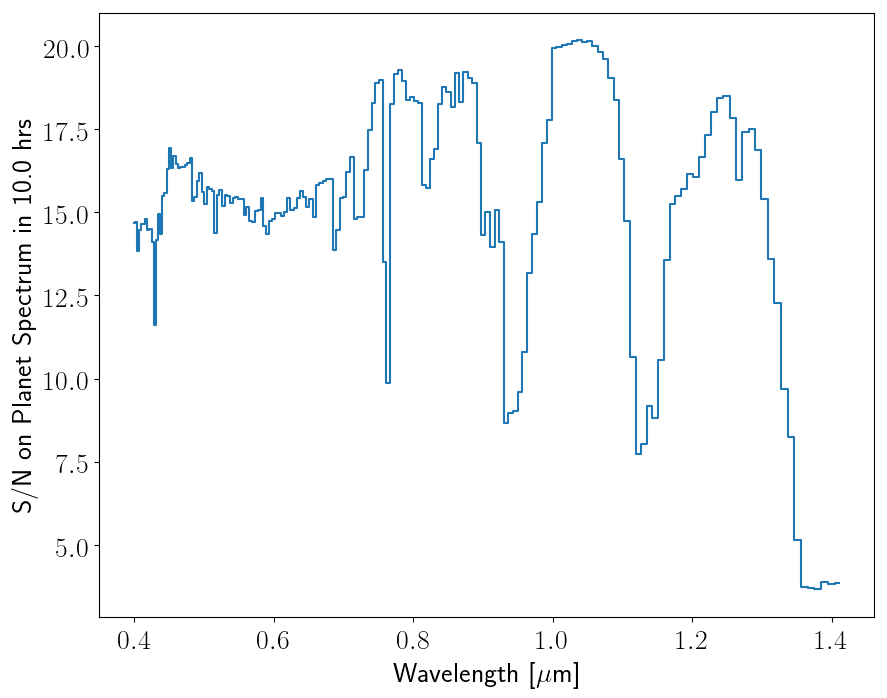

In [28]:
fig, ax = cn.plot_SNR()

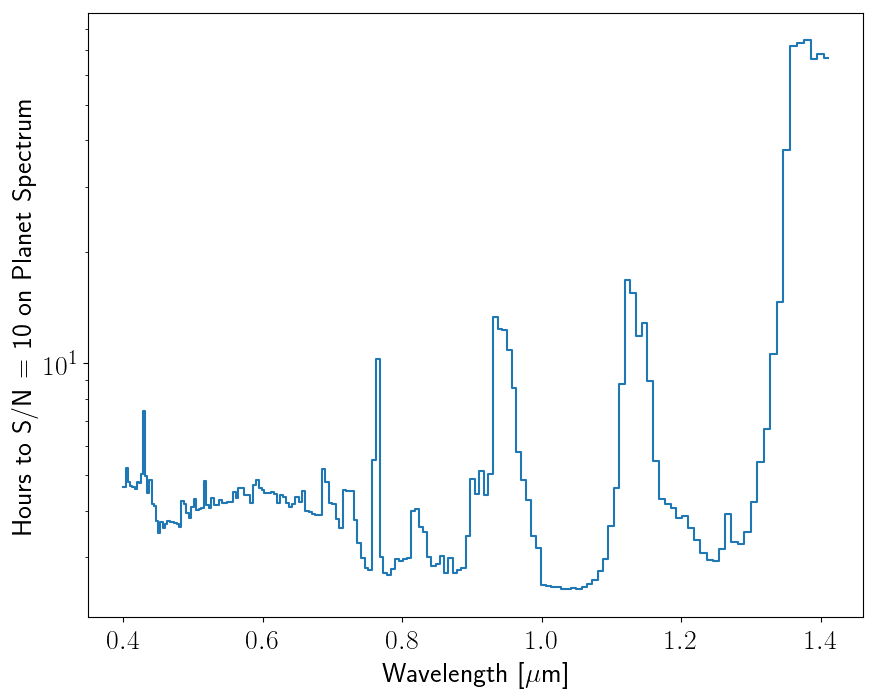

In [29]:
fig, ax = cn.plot_time_to_wantsnr()

In [139]:
# Set nominal SNR and exposure time values
wantSNR = 10.0
wantetime = 5.0
cn.make_fake_data(texp = wantetime)

2.21 hours to SNR = 10.00
SNR = 15.05 on band in a 5.00 hour exposure
SNR = 27.35 on bottom of band in a 5.00 hour exposure


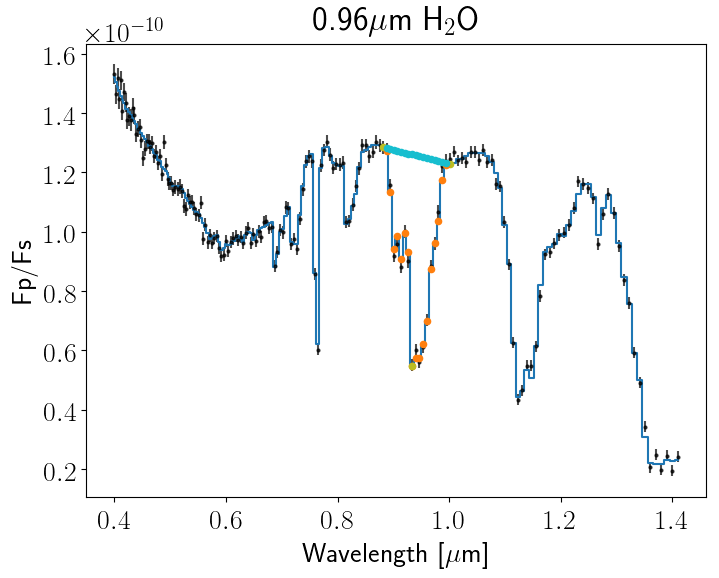

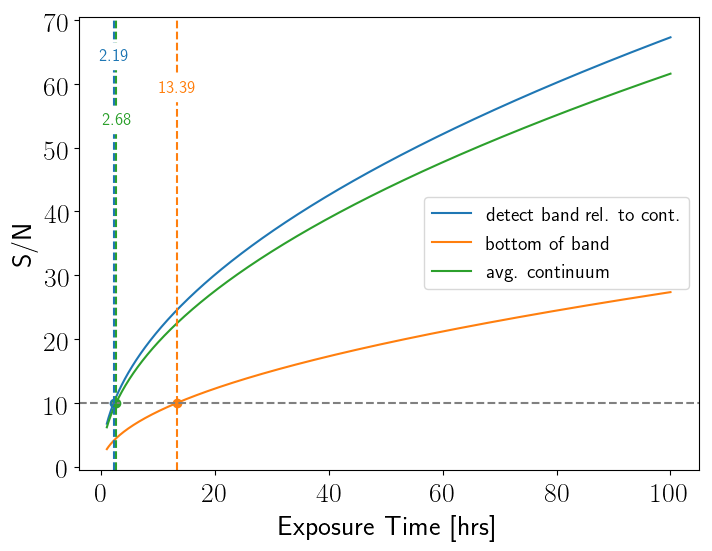

In [147]:
"""
# Specify band via array indices
icont = np.array([111, 128])
iband = np.arange(icont[0]+1, icont[1])
ibottom = 119
"""

# Specify band via wavelength
bandlims = [0.88, 1.0]
icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
iband = np.arange(icont[0]+1, icont[1])
ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

# Construct noised spectrum plot
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cn.lam, cn.Cratio, ls = "steps-mid")
ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "ok", ms = 2.0, alpha = 0.7)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")
ax.set_title("0.96$\mu$m H$_2$O")

# Identify specific points in band
for i in icont:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
for i in iband:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)

# Calculate the continuum planet photon counts and contrast ratio
ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

# Identify specific continuum points in band
for i, ic in enumerate(iband):
    ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)

# Calculate the exposure time to get desired SNR on band
etime = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
print("%.2f hours to SNR = %.2f" %(etime, wantSNR))

# Calculate the SNR on band in desired exposure time
eSNR = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=wantetime)
print("SNR = %.2f on band in a %.2f hour exposure" %(eSNR, wantetime))

print("SNR = %.2f on bottom of band in a %.2f hour exposure" %(cn.SNRt[ibottom], wantetime))

if True:
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])

    # Find nearest points to desired values
    #etime_band = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
    etime_band = times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = times[np.argmin(np.fabs(cont_snrs - wantSNR))]

    # Make plot of SNR vs exposure time
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("Exposure Time [hrs]")
    ax.set_ylabel("S/N")
    ax.plot(times, band_snrs, label = "detect band rel. to cont.")
    ax.plot(times, bot_snrs, label = "bottom of band")
    ax.plot(times, cont_snrs, label = "avg. continuum")
    ax.scatter(etime_band, wantSNR, c="C0")
    ax.scatter(etime_bot, wantSNR, c="C1")
    ax.scatter(etime_cont, wantSNR, c="C2")
    ax.axhline(wantSNR, ls = "--", c = "grey")
    ax.axvline(etime_band, ls = "--", c = "C0")
    ax.axvline(etime_bot, ls = "--", c = "C1")
    ax.axvline(etime_cont, ls = "--", c = "C2")
    ylims = ax.get_ylim()
    ax.text(etime_band, ylims[1]-5, "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
    ax.text(etime_bot, ylims[1]-10, "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
    ax.text(etime_cont, ylims[1]-15, "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
    ax.legend(framealpha = 0.75, fontsize = 14)

16.48 hours to SNR = 10.00
SNR = 5.51 on band in a 5.00 hour exposure
SNR = 31.20 on bottom of band in a 5.00 hour exposure


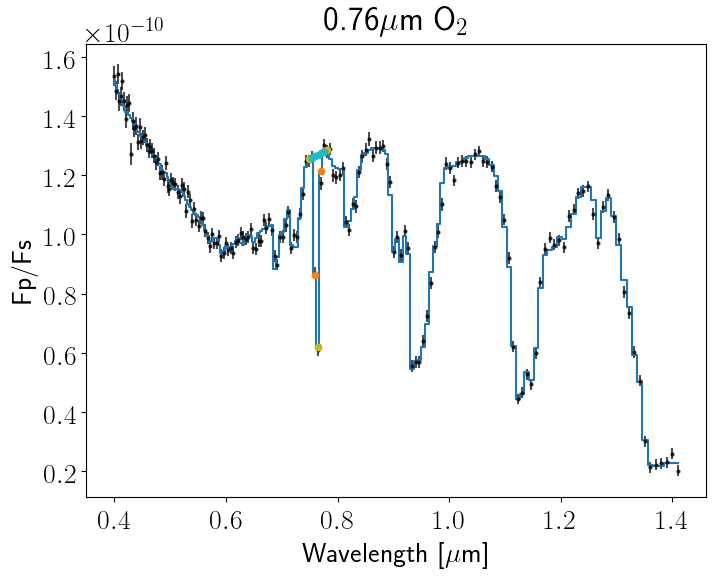

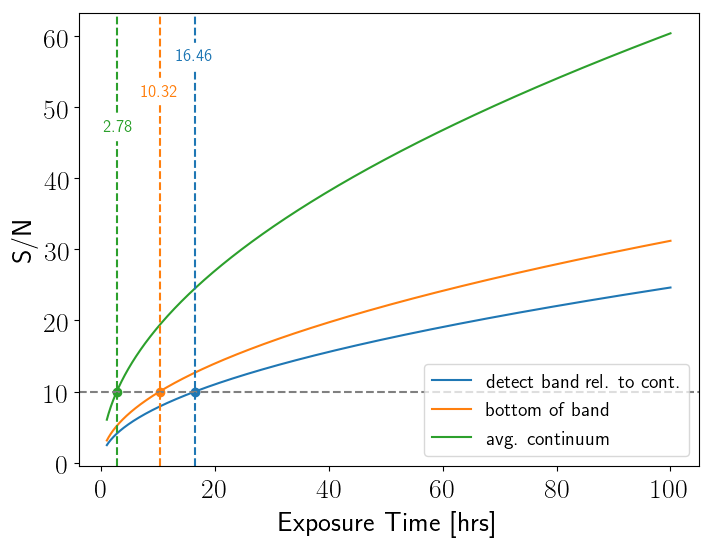

In [151]:
# Specify band via wavelength
bandlims = [0.75, 0.78]
icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
iband = np.arange(icont[0]+1, icont[1])
ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))

# Construct noised spectrum plot
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(cn.lam, cn.Cratio, ls = "steps-mid")
ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "ok", ms = 2.0, alpha = 0.7)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Fp/Fs")
ax.set_title("0.76$\mu$m O$_2$")

# Identify specific points in band
for i in icont:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
for i in iband:
    ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)

# Calculate the continuum planet photon counts and contrast ratio
ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)

# Identify specific continuum points in band
for i, ic in enumerate(iband):
    ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)

# Calculate the exposure time to get desired SNR on band
etime = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
print("%.2f hours to SNR = %.2f" %(etime, wantSNR))

# Calculate the SNR on band in desired exposure time
eSNR = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=wantetime)
print("SNR = %.2f on band in a %.2f hour exposure" %(eSNR, wantetime))

print("SNR = %.2f on bottom of band in a %.2f hour exposure" %(cn.SNRt[ibottom], wantetime))

if True:
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])

    # Find nearest points to desired values
    #etime_band = cg.observe.exptime_band(cn.cp, ccont, cn.cb, iband, SNR=wantSNR)
    etime_band = times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = times[np.argmin(np.fabs(cont_snrs - wantSNR))]

    # Make plot of SNR vs exposure time
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_xlabel("Exposure Time [hrs]")
    ax.set_ylabel("S/N")
    ax.plot(times, band_snrs, label = "detect band rel. to cont.")
    ax.plot(times, bot_snrs, label = "bottom of band")
    ax.plot(times, cont_snrs, label = "avg. continuum")
    ax.scatter(etime_band, wantSNR, c="C0")
    ax.scatter(etime_bot, wantSNR, c="C1")
    ax.scatter(etime_cont, wantSNR, c="C2")
    ax.axhline(wantSNR, ls = "--", c = "grey")
    ax.axvline(etime_band, ls = "--", c = "C0")
    ax.axvline(etime_bot, ls = "--", c = "C1")
    ax.axvline(etime_cont, ls = "--", c = "C2")
    ylims = ax.get_ylim()
    ax.text(etime_band, ylims[1]-5, "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
    ax.text(etime_bot, ylims[1]-10, "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
    ax.text(etime_cont, ylims[1]-15, "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
    ax.legend(framealpha = 0.75, fontsize = 14)

# Refining Code into a useful function

In [600]:
from scipy import stats

def find_time_from_snr(times, snrs, wantsnr):
    """
    """
    
    x = times
    y = snrs**2
    
    # Fit S/N**2 curve with a line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_fit = slope * x + intercept
    snr_fit = np.sqrt(y_fit)

    # Solve for number of occultations to get desired SNR
    t_snr = (wantsnr**2 - intercept) / slope
    
    return t_snr

def determine_exposure_time(cn, bandlims, wantSNR = 10.0, wantetime = 5.0, 
                            plot_snr_curves = False, plot_spectrum = False, 
                            title = ""):
    """
    Determine the exposure time needed to get a desired S/N
    
    Parameters
    ----------
    cn : :class:`coronagraph.CoronagraphNoise`
        Instantiated ``CoronagraphNoise`` object containing ``Telescope``, ``Planet``, and ``Star`` 
        objects with their associated parameters
    bandlims : list or tuple
        Lower and upper wavelength limits to absorption band [microns]
        
    Returns
    -------
    etime_band : float 
        Exposure time to get S/N on band below the continuum
    etime_bot : float 
        Exposure time to get S/N on spectral element at the bottom of the band
    etime_cont : float
        Exposure time to ger S/N on the spectral elements in the continuum nearest to the band
    """
    
    # Specify band via wavelength
    icont = np.array([np.argmin(np.fabs(cn.lam - bandlims[0])), np.argmin(np.fabs(cn.lam - bandlims[1]))])
    iband = np.arange(icont[0]+1, icont[1])
    ibottom = np.argmin(np.fabs(cn.Cratio - np.min(cn.Cratio[iband])))
    
    # Specify Kat's fiducial S/N
    i550nm = np.argmin(np.fabs(cn.lam - 0.550))
    
    # Calculate the continuum planet photon counts and contrast ratio
    ccont = cg.observe.interp_cont_over_band(cn.lam, cn.cp, icont, iband)
    ccrat = cg.observe.interp_cont_over_band(cn.lam, cn.Cratio, icont, iband)
    
    # Calculate varies SNRs as a function of exposure time 
    Nt = 1000
    times = np.linspace(1.0, 100.0, Nt)
    band_snrs = np.zeros(len(times))
    bot_snrs = np.zeros(len(times))
    cont_snrs = np.zeros(len(times))
    fid_snrs = np.zeros(len(times))
    for i, time in enumerate(times):
        cn.make_fake_data(texp = times[i])
        band_snrs[i] = cg.observe.SNR_band(cn.cp, ccont, cn.cb, iband, itime=times[i])
        bot_snrs[i] = cn.SNRt[ibottom]
        cont_snrs[i] = np.mean(cn.SNRt[icont])
        fid_snrs[i] = cn.SNRt[i550nm]
    
    # Fit for time to desired snr value
    etime_band = find_time_from_snr(times, band_snrs, wantSNR) #times[np.argmin(np.fabs(band_snrs - wantSNR))]
    etime_bot = find_time_from_snr(times, bot_snrs, wantSNR) #times[np.argmin(np.fabs(bot_snrs - wantSNR))]
    etime_cont = find_time_from_snr(times, cont_snrs, wantSNR) #times[np.argmin(np.fabs(cont_snrs - wantSNR))]
    etime_fid = find_time_from_snr(times, fid_snrs, wantSNR) #times[np.argmin(np.fabs(fid_snrs - wantSNR))]
    
    # Check for incomplete bands which can cause anomalously low exposure times
    if False in np.isfinite(cn.Cobs[iband]):
        etime_band = np.nan
    
    if plot_snr_curves:
        # Make plot of SNR vs exposure time
        fig, ax = plt.subplots(figsize = (8,6))
        ax.set_xlabel("Exposure Time [hrs]")
        ax.set_ylabel("S/N")
        ax.plot(times, band_snrs, label = "detect band rel. to cont.")
        ax.plot(times, bot_snrs, label = "bottom of band")
        ax.plot(times, cont_snrs, label = "avg. continuum")
        ax.plot(times, fid_snrs, label = "at 550 nm")
        ax.scatter(etime_band, wantSNR, c="C0")
        ax.scatter(etime_bot, wantSNR, c="C1")
        ax.scatter(etime_cont, wantSNR, c="C2")
        ax.scatter(etime_fid, wantSNR, c="C3")
        ax.axhline(wantSNR, ls = "--", c = "grey")
        ax.axvline(etime_band, ls = "--", c = "C0")
        ax.axvline(etime_bot, ls = "--", c = "C1")
        ax.axvline(etime_cont, ls = "--", c = "C2")
        ax.axvline(etime_fid, ls = "--", c = "C3")
        ylims = ax.get_ylim()
        ax.text(etime_band, ylims[1]-.5*ylims[1], "%.2f" %etime_band, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C0")
        ax.text(etime_bot, ylims[1]-.1*ylims[1], "%.2f" %etime_bot, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C1")
        ax.text(etime_cont, ylims[1]-.15*ylims[1], "%.2f" %etime_cont, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C2")
        ax.text(etime_fid, ylims[1]-.20*ylims[1], "%.2f" %etime_fid, ha = "center", va = "top", fontsize = 12, bbox=dict(facecolor='w', alpha=1.0, ec = "w"), color = "C3")
        ax.legend(framealpha = 0.75, fontsize = 14)
        
    if plot_spectrum:
        # Construct noised spectrum plot
        cn.make_fake_data(texp = etime_band)
        fig, ax = plt.subplots(figsize = (8,6))
        ax.plot(cn.lam, cn.Cratio, ls = "steps-mid", color = "grey")
        ax.errorbar(cn.lam, cn.Cobs, yerr=cn.Csig, fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        ax.set_xlabel("Wavelength [$\mu$m]")
        ax.set_ylabel("Fp/Fs")
        ax.set_title(title)
        # Identify specific points in band
        for i in icont:
            ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C8", marker = "o", zorder = 100)
        for i in iband:
            ax.scatter(cn.lam[i], cn.Cratio[i], s = 20.0, c = "C1", marker = "o", zorder = 100)
        ax.scatter(cn.lam[ibottom], cn.Cratio[ibottom], s = 20.0, c = "C8", marker = "o", zorder = 100)
        # Identify specific continuum points in band
        for i, ic in enumerate(iband):
            ax.scatter(cn.lam[ic], ccrat[i], s = 20.0, c = "C9", marker = "o", zorder = 100)
            
    # Return exposure times
    return etime_band, etime_bot, etime_cont, etime_fid
        

In [599]:
False in np.isfinite(np.array([1, 2, 3, np.nan, np.nan]))

True

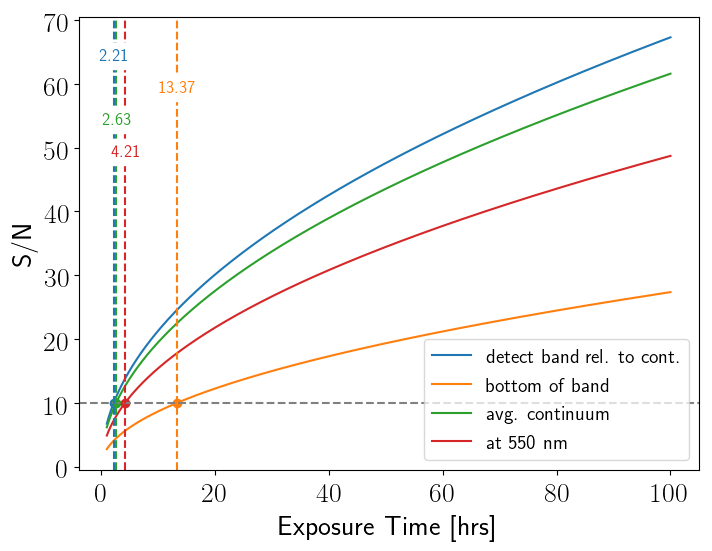

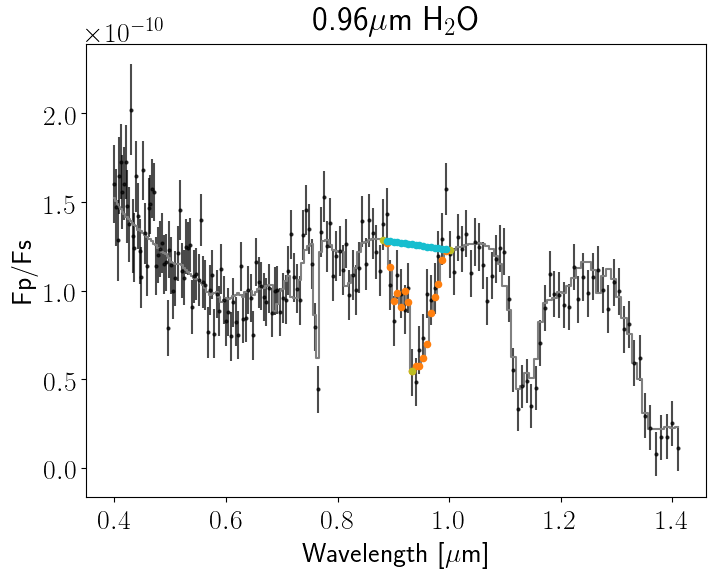

In [275]:
etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=True, plot_spectrum=True)

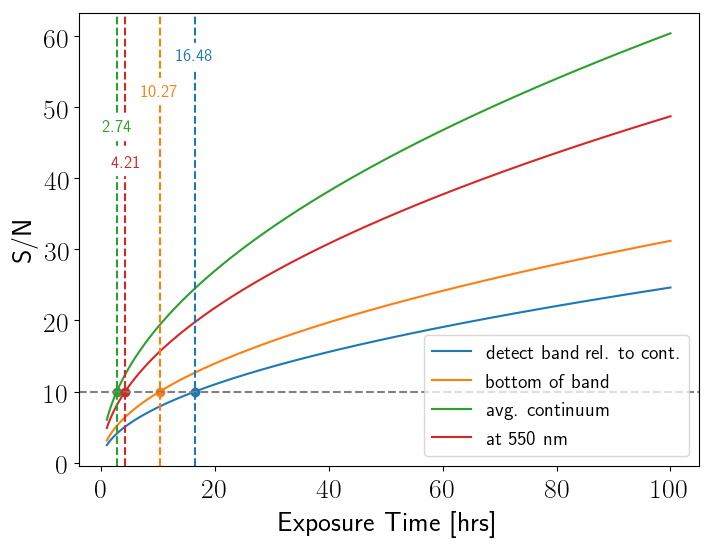

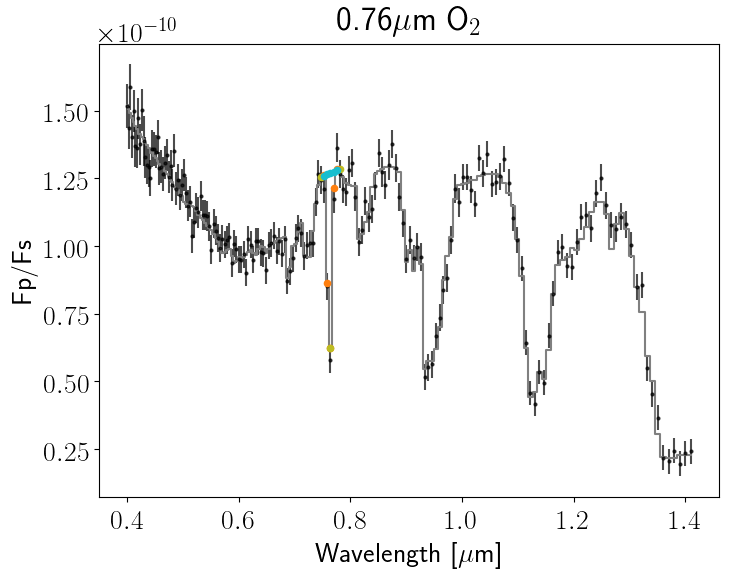

In [276]:
etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=True, plot_spectrum=True)

# Using the code

Load-in Exoplanet Spectrum:

In [237]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

Set telescope, planet, and star parameters:

In [238]:
telescope = cg.Telescope(lammin = 0.4, 
                         lammax = 1.4, 
                         R = 140, 
                         Tput = 0.1, 
                         D = 16.
                        )

planet = cg.Planet(d = 5.0, 
                   Rp = 1.0, 
                   a = 1.0, 
                   alpha = 90.0
                  )

star = cg.Star(Teff = 5780., 
               Rs = 1.0
              )

Create a simulation that holds the above parameters:

In [239]:
cn = cg.CoronagraphNoise(telescope = telescope, 
                         planet = planet, 
                         star = star, 
                         THERMAL=True)

Calculate the photon count rates for observing this spectrum with the specified telescope and system setup:

In [240]:
cn.run_count_rates(Ahr, lamhr, fstar)

Determine the exposure time for a single band:

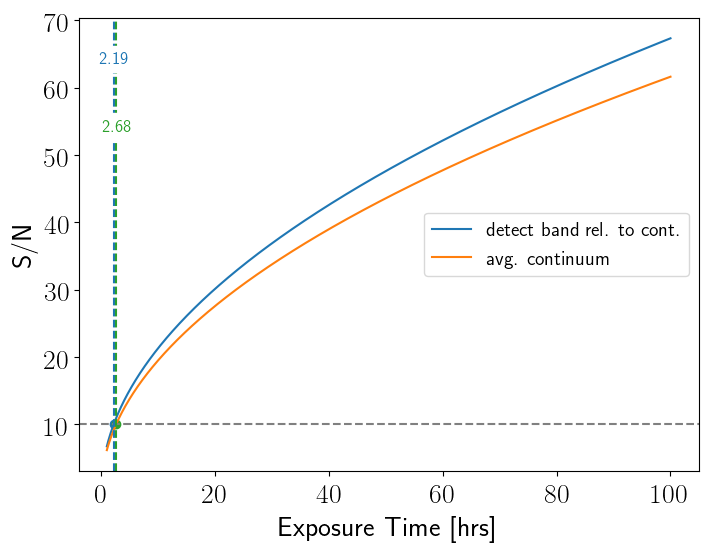

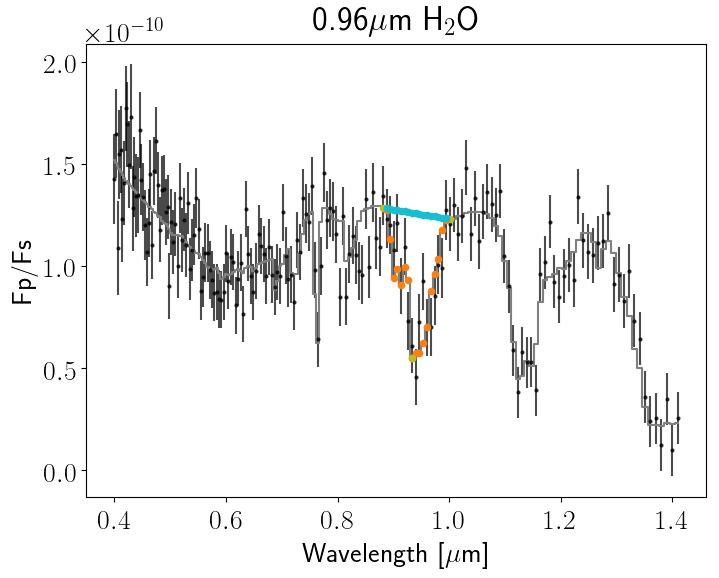

In [241]:
etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=True, plot_spectrum=True)

# Applying to some real systems

In [256]:
from astroquery.simbad import Simbad
from astropy.table import Table, vstack

def read_simbad_table(obj_name, **kwargs):
    """Read in Astroquery results from Simbad given object name (str)
    
    Parameter
    ---------
    obj_name : (str or list of str) name(s) of object
    
    kwargs (optional)
    ------
    votfields : (list) list of votable field keywords, from http://simbad.u-strasbg.fr/Pages/guide/sim-fscript.htx
                default is ['sptype', 'fluxdata(V)', 'velocity', 'distance']
    """
    customSimbad = Simbad()
    votfields = kwargs.pop('votfields', ['sptype', 'fluxdata(V)', 'velocity', 'distance'])
#    customSimbad.add_votable_fields('sptype')
#    customSimbad.add_votable_fields('fluxdata(V)')
#    customSimbad.add_votable_fields('velocity')
#    customSimbad.add_votable_fields('distance')
    for vf in votfields:
        customSimbad.add_votable_fields(vf)
    if type(obj_name) is str:
        result_table = customSimbad.query_object(obj_name)
    else:
        result_table = customSimbad.query_objects(obj_name)
    return result_table

In [259]:
## read in the biased draw from Aki and make 5 unbiased draws from them
Ndraw=5
obj_names_all = np.loadtxt('../inputs/luvoir-A_stars.txt', usecols=(0,), delimiter=',', skiprows=1).astype(int)
obj_names = np.random.choice(obj_names_all, size=Ndraw, replace=False)
print(obj_names)

votfields = ['sptype', 'fluxdata(V)', 'distance', 'diameter', 'fe_h']

## stack each Simbad query results vertically in Astropy Table
result = read_simbad_table("Hip"+str(obj_names[0]), votfields = votfields)
for ii in range(1,len(obj_names)):
    result = vstack([result, read_simbad_table("Hip"+str(obj_names[ii]))])
    
print(result)

[98959 22449 18859 98959 14632]


  MAIN_ID         RA           DEC      ... RVZ_WAVELENGTH     RVZ_BIBCODE    
               "h:m:s"       "d:m:s"    ...                                   
----------- ------------- ------------- ... -------------- -------------------
  HD 189567 20 05 32.7652 -67 19 15.228 ...             --                  --
* pi.03 Ori 04 49 50.4109 +06 57 40.588 ...              O 2017AJ....153...75K
  HD  25457 04 02 36.7451 -00 16 08.118 ...                2011AAS...21743412C
  HD 189567 20 05 32.7652 -67 19 15.228 ...              O 2018yCat.1345....0G
  * iot Per 03 09 04.0198 +49 36 47.799 ...                2002ApJS..141..503N


In [260]:
result

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,FILTER_NAME_V,FLUX_V,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_BIBCODE_V,FLUX_VAR_V,FLUX_MULT_V,FLUX_QUAL_V,FLUX_UNIT_V,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,Diameter_diameter,Diameter_Q,Diameter_unit,Diameter_error,Diameter_filter,Diameter_method,Diameter_bibcode,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,Fe_H_CompStar,Fe_H_CatNo,Fe_H_bibcode,RVZ_TYPE,RVZ_RADVEL,RVZ_ERROR,RVZ_QUAL,RVZ_WAVELENGTH,RVZ_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,mag,,,,,,,,,,,,,,,,,,,,,,unit-degK,cm/s**2,,,,,,,km / s,km / s,,,
object,unicode13,unicode13,int16,int16,float32,float32,int16,unicode1,unicode1,object,object,unicode1,object,object,float32,float32,object,object,unicode1,object,unicode1,unicode1,float64,unicode1,unicode4,float64,float64,unicode8,unicode19,float64,unicode1,unicode4,float64,unicode8,unicode8,unicode19,int32,float32,float32,unicode1,object,unicode5,unicode19,unicode1,float64,float32,unicode1,unicode1,object
HD 189567,20 05 32.7652,-67 19 15.228,14,14,0.021,0.032,90,A,O,2018yCat.1345....0G,G2V,C,2006AJ....132..161G,V,6.07,--,Vega,2002yCat.2237....0D,,,C,V,17.9148,,pc,-0.0122,0.0122,paral,2018yCat.1345....0G,--,,,--,,,,5765,--,--,,SUN,,2011A&A...530A.138C,--,--,--,--,--,--
* pi.03 Ori,04 49 50.4109,+06 57 40.588,11,11,0.150,0.090,90,A,O,2007A&A...474..653V,F6V,B,1973ARA&A..11...29M,V,3.19,0.009,Vega,1993A&AS..100..591O,,,C,V,8.0419,,pc,-0.0253,0.0253,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,22.411,0.520,A,O,2017AJ....153...75K
HD 25457,04 02 36.7451,-00 16 08.118,14,14,0.097,0.065,90,A,O,2018yCat.1345....0G,F7/8V,D,1999MSS...C05....0H,V,5.38,--,Vega,,,,C,V,18.7712,,pc,-0.0408,0.0408,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,17.620,0.160,A,,2011AAS...21743412C
HD 189567,20 05 32.7652,-67 19 15.228,14,14,0.021,0.032,90,A,O,2018yCat.1345....0G,G2V,C,2006AJ....132..161G,V,6.07,--,Vega,2002yCat.2237....0D,,,C,V,17.9148,,pc,-0.0122,0.0122,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,-10.610,0.150,A,O,2018yCat.1345....0G
* iot Per,03 09 04.0198,+49 36 47.799,11,11,0.160,0.150,90,A,O,2007A&A...474..653V,G0V,B,1989ApJS...71..245K,V,4.05,0.050,Vega,2009ApJ...694.1085V,,,C,V,10.5088,,pc,-0.0334,0.0334,paral,2018yCat.1345....0G,--,--,--,--,--,--,--,--,--,--,--,--,--,--,v,49.220,0.080,A,,2002ApJS..141..503N


In [208]:
# Read in table of 50 biased draws 
data = np.loadtxt('../inputs/luvoir-A_stars.txt', delimiter=',', skiprows=1, dtype = str)

# Parse
hip = np.array(data[:,0], dtype=int)
dist = np.array(data[:,1], dtype=float)
stype = np.array(data[:,2], dtype=str)

In [340]:
# Read in table of stellar types
data = np.loadtxt('../inputs/stellar_properties.txt', skiprows=19, dtype = str)
data = pd.DataFrame(data, columns=["Stellar Type", "Mass", "Luminosity", "Radius", "Temp", 
                                   "B-V", "Mv", "BC(Temp)", "Mbol", "R", "G", "B"])
data.head()

,Stellar Type,Mass,Luminosity,Radius,Temp,B-V,Mv,BC(Temp),Mbol,R,G,B
0,O0Ia0,160.0,3.41e+07,8.02e+01,50000,-0.35,-9.5,-4.58,-14.08,144,166,255
1,O0Ia,150.0,2.59e+06,2.21e+01,50000,-0.35,-6.7,-4.58,-11.28,144,166,255
2,O0Ib,140.0,2.15e+06,2.02e+01,50000,-0.35,-6.5,-4.58,-11.08,144,166,255
3,O0II,130.0,2.15e+06,2.02e+01,50000,-0.35,-6.5,-4.58,-11.08,144,166,255
4,O0III,120.0,2.15e+06,2.02e+01,50000,-0.35,-6.5,-4.58,-11.08,144,166,255


In [347]:
# Read in table of stellar types
data = np.loadtxt('../inputs/stellar_properties.txt', skiprows=19, dtype = str)

stypes = data[:,0] 
masses = np.array(data[:,1], dtype=float)
lums = np.array(data[:,2], dtype=float)
rads = np.array(data[:,3], dtype=float)
temps = np.array(data[:,4], dtype=float)
mvs = np.array(data[:,6], dtype=float)

In [417]:
def match_stellar_type(s, verbose = True):
    """
    Match stellar type ``s`` with the table of stellar types and return the index in table 
    that matches
    """
    for i, st in enumerate(stypes):
        if s == st:
            return i
    if verbose: print("No exact match found")
    for i, st in enumerate(stypes):
        if s.startswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s.endswith(st):
            if verbose: print("Using %s for %s" %(st, s))
            return i
    for i, st in enumerate(stypes):
        if s+"V" == st:
            if verbose: print("Using %s for %s" %(st, s))
            return i

In [470]:
Ndraw = 5
np.random.seed(seed=1)
idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

In [471]:
print("Randomly Drawn Stars")
print("--------------------")
for i in idraw:
    print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    print(stypes[match_stellar_type(stype[i])])

Randomly Drawn Stars
--------------------
HIP 19335, 21.26 pc, F7V 
F7V
HIP 57757, 10.93 pc, F8V 
F8V
HIP 116085, 16.87 pc, K2V 
K2V
HIP 48113, 18.37 pc, G2V 
G2V
HIP 15371, 12.03 pc, G1V 
G1V


### The Habitable Zone

Using the HZs for different stellar types from [Kopparapu et al. (2013)](http://iopscience.iop.org/article/10.1088/0004-637X/765/2/131/meta):

In [421]:
def calc_seff(Teff, S0, coeffs):
    a, b, c, d = coeffs
    T = Teff - 5780.
    return S0 + a*T + b*T**2 + c*T**3 + d*T**4

def calc_dist(L, Seff):
    return (L / Seff)**0.5

# Using the moist greenhouse inner edge
S0_inner = 1.0140
inner_edge = [8.1774e-5, 1.7063e-9, -4.3241e-12, -6.6462e-16]

# Using the maximum greenhouse outer edge
S0_outer = 0.3438
outer_edge = [5.8942e-5, 1.6558e-9, -3.0045e-12, -5.2983e-16]

In [442]:
Ndraw = 1
idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

print("Randomly Drawn Stars")
print("--------------------")
for i in idraw:
    print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    imatch = match_stellar_type(stype[i])
    print(stypes[imatch])
    a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
    a_eeq = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)

Randomly Drawn Stars
--------------------
HIP 85523, 4.54 pc, K5 
No exact match found
Using K5V for K5
K5V
HZ limits : 0.54 - 1.01 au
Earth-Equivalent Insolation Distance : 0.52 au


# Example random sampling

In [315]:
def nsig_intervals(x, intvls=[0.16, 0.5, 0.84]):
    # Compute median and n-sigma intervals
    q_l, q_50, q_h = np.percentile(x, list(100.0 * np.array(intvls)))
    q_m, q_p = q_50-q_l, q_h-q_50
    return q_l, q_50, q_h, q_m, q_p

In [443]:
Xdraw = 200    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample

np.random.seed(seed=None)

# Allocate memory for exposure times
ctime_band = np.zeros((Ndraw, Xdraw))
ctime_bot = np.zeros((Ndraw, Xdraw))
ctime_cont = np.zeros((Ndraw, Xdraw))
ctime_fid = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)
    
    # Order systems by "detectability"
    idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Loop over stars in this sample
    for i, j in enumerate(idraw):
        #print("HIP %i, %.2f pc, %s " %(hip[j], dist[j], stype[j]))
        
        # Get index with matching stellar type in stellar properties table
        imatch = match_stellar_type(stype[j], verbose = False)
        
        # Set system distance
        cn.planet.distance = dist[j]
        
        # Set stellar temperature
        cn.star.Teff = temps[imatch]
        
        # Set stellar radius
        cn.star.Rs = rads[imatch]
        
        # Calculate the Earth-equivalent insolation distance
        a_eeq = np.sqrt(lums[imatch])
        
        # Set semi-major axis 
        cn.planet.a = a_eeq
        
        # Set stellar spectrum based on type
        # Calculate stellar flux at TOA assuming a blackbody
        Fs = cg.noise_routines.Fstar(lamhr, cn.star.Teff, cn.star.Rs, cn.planet.a, AU=True)
        #Fs = fstar
        
        # Run count rates
        cn.run_count_rates(Ahr, lamhr, Fs)
        etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=False, plot_spectrum=False)
        #etime_band, etime_bot, etime_cont, etime_fid = etimes
        
        # Parse and distribute results
        ctime_band[i, ix] += etimes[0]
        ctime_bot[i, ix] += etimes[1]
        ctime_cont[i, ix] += etimes[2]
        ctime_fid[i, ix] += etimes[3]
    
#print(ctime_band, ctime_bot, ctime_cont)

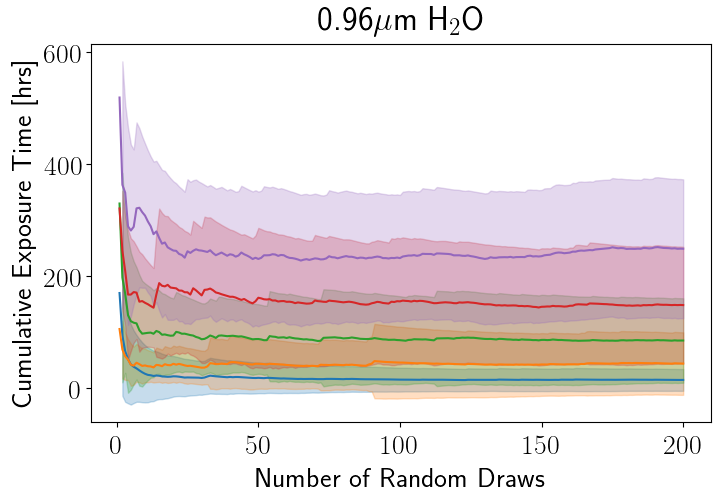

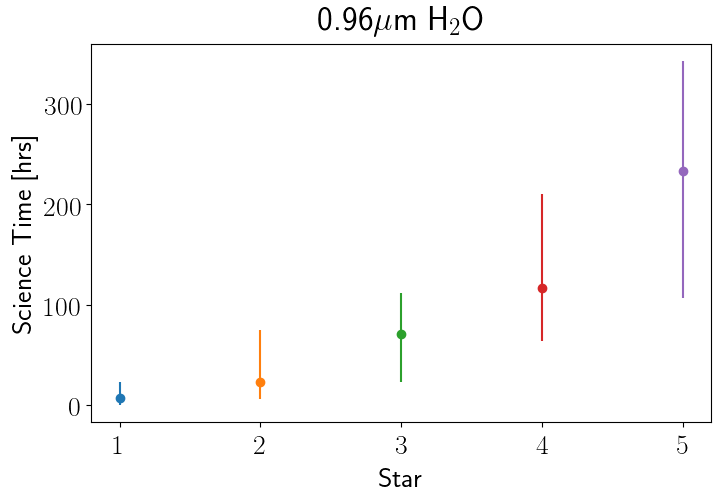

In [448]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean = pd.Series(ctime_band[i,:]).expanding(1).mean().values
    
    # Calculate the cumulative std deviation 
    cumstd = pd.Series(ctime_band[i,:]).expanding(1).std().values
    
    # Plot
    ax.plot((np.arange(Xdraw)+1), cummean, c = "C%i" %i)
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax.fill_between(np.arange(Xdraw)+1, cummean - cumstd, cummean + cumstd, alpha = 0.25, color = "C%i" %i)
    ax.set_xlabel("Number of Random Draws")
    ax.set_ylabel("Cumulative Exposure Time [hrs]")
    ax.set_title("0.96$\mu$m H$_2$O")
    
    q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_band[i,:], intvls=[0.16, 0.5, 0.84])
    ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C%i" %i)
    ax2.set_xlabel("Star")
    ax2.set_ylabel("Science Time [hrs]")
    ax2.set_title("0.96$\mu$m H$_2$O")
    #ax2.set_yscale("log")

In [584]:
def prep_ith_star(cn, i):
    """
    Takes a :class:`coronagraph.CoronagraphNoise` object and an index and returns the object 
    with parameters set for that system. 
    
    Note
    ----
    Currently requires a bunch of arrays to exist outside of this functions scope, 
    e.g. `stype`, `dist`, `temps`, `rads`, `lums`
    """
    
    # Get index with matching stellar type in stellar properties table
    imatch = match_stellar_type(stype[i], verbose = False)
    
    # Set system distance
    cn.planet.distance = dist[i]

    # Set stellar temperature
    cn.star.Teff = temps[imatch]

    # Set stellar radius
    cn.star.Rs = rads[imatch]

    # Calculate the Earth-equivalent insolation distance
    a_eeq = np.sqrt(lums[imatch])

    # Set semi-major axis 
    cn.planet.a = a_eeq

    # Set stellar spectrum based on type
    # Calculate stellar flux at TOA assuming a blackbody
    Fs = cg.noise_routines.Fstar(lamhr, cn.star.Teff, cn.star.Rs, cn.planet.a, AU=True)
    #Fs = fstar

    # Run count rates
    cn.run_count_rates(Ahr, lamhr, Fs)
    
    return cn

### Use "True" LUVOIR parameters

In [532]:
def default_luvoir(architecture = "A", channel = "vis"):
    """
    Returns the :class:`coronagraph.Telescope` for the `architecture` and 
    `channel` specified by the user. 
    """
    
    telescope = cg.Telescope()
    
    if (architecture.lower() == "A".lower()):
        telescope.diameter = 13.5
        telescope.A_collect = 155.
        telescope.Tsys = 270.
        telescope.OWA = 64.
        if channel.lower() == "vis".lower():
            telescope.IWA = 3.5
            telescope.resolution = 150.
            telescope.throughput = 0.15
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.5
            telescope.lammax = 1.03
        elif channel.lower() == "UV".lower():
            telescope.IWA = 3.5
            telescope.resolution = 10.
            telescope.throughput = 0.15
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.2
            telescope.lammax = 0.5
        elif channel.lower() == "NIR".lower():
            telescope.IWA = 2.4
            telescope.resolution = 150.
            telescope.throughput = 0.15
            telescope.darkcurrent = 2e-3
            telescope.readnoise = 2.5
            telescope.lammin = 1.03
            telescope.lammax = 1.8
        else:
            print("Unknown `channel`")
            return None
    elif (architecture.lower() == "B".lower()):
        telescope.diameter = 6.7
        telescope.A_collect = 43.8
        telescope.Tsys = 270.
        telescope.OWA = 64.
        if channel.lower() == "vis".lower():
            telescope.IWA = 2.4
            telescope.resolution = 150.
            telescope.throughput = 0.18
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.5
            telescope.lammax = 1.03
        elif channel.lower() == "UV".lower():
            telescope.IWA = 3.5
            telescope.resolution = 10.
            telescope.throughput = 0.18
            telescope.darkcurrent = 3e-5
            telescope.readnoise = 1e-2
            telescope.lammin = 0.2
            telescope.lammax = 0.5
        elif channel.lower() == "NIR".lower():
            telescope.IWA = 2.4
            telescope.resolution = 150.
            telescope.throughput = 0.18
            telescope.darkcurrent = 2e-3
            telescope.readnoise = 2.5
            telescope.lammin = 1.03
            telescope.lammax = 1.8
        else:
            print("Unknown `channel`")
            return None
    else:
        print("Unknown `architecture`")
        return None
    
    return telescope

In [491]:
channels = ["UV", "vis", "NIR"]
arch = "A"

luvoir_A = []
for channel in channels:
    luvoir_A.append(default_luvoir(architecture = arch, channel = channel))

In [541]:
cn.telescope = default_luvoir(architecture="A", channel="NIR")

In [542]:
cn.run_count_rates(Ahr, lamhr, fstar)

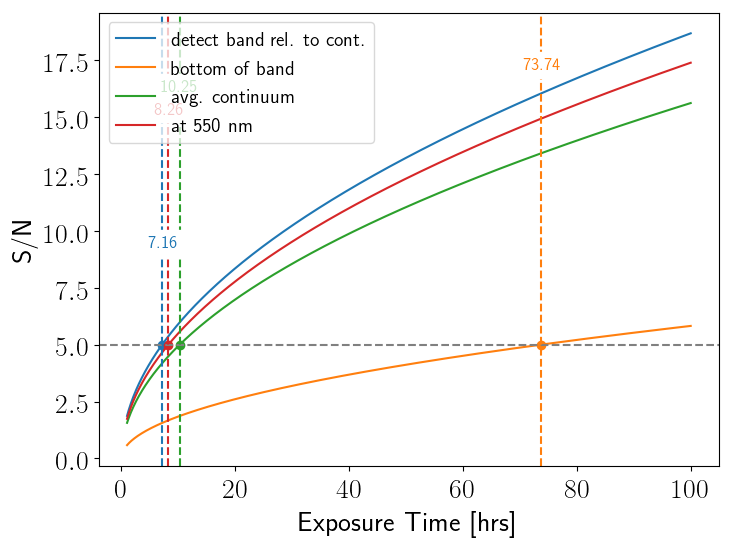

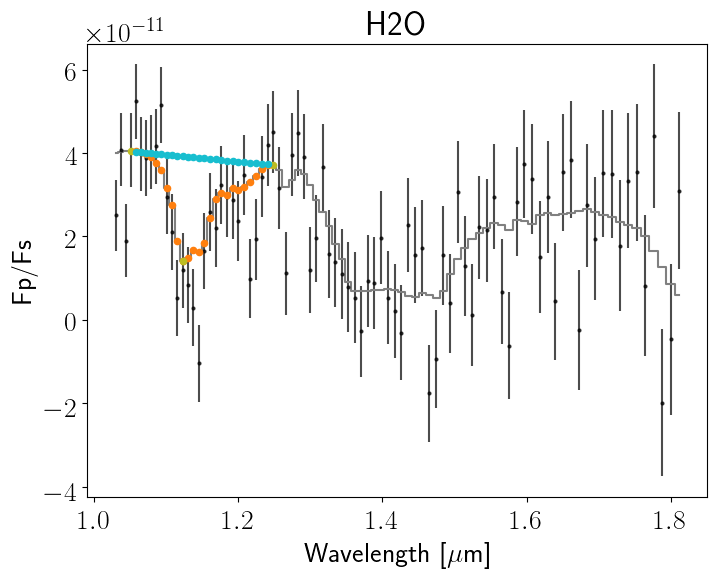

In [548]:
etimes = determine_exposure_time(cn, [1.05, 1.25], title = "H2O", plot_snr_curves=True, plot_spectrum=True, wantSNR=5)

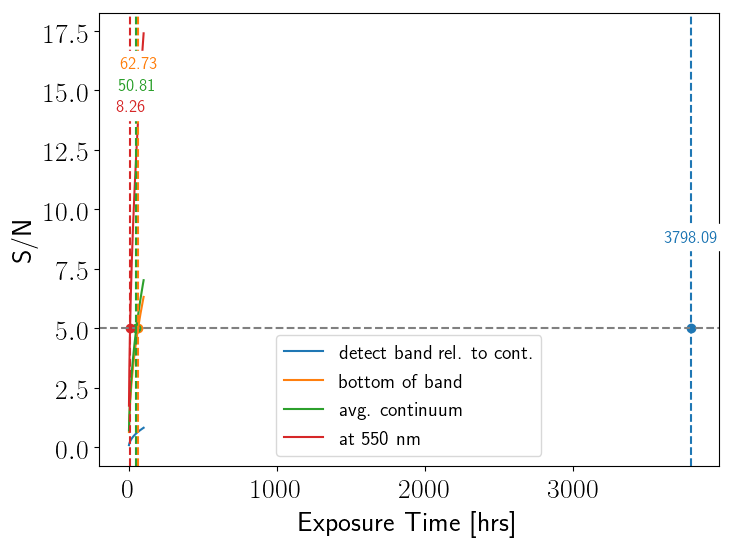

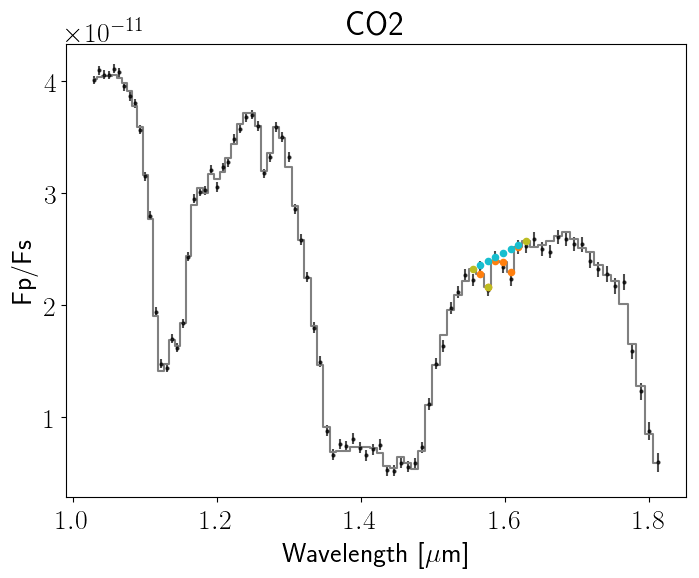

In [552]:
etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=True, plot_spectrum=True, wantSNR=5)

# Determine exposure times for all potential stellar targets  
Can do the random sampling later w/o calling cg model

In [601]:
Ndraw = len(dist)      # Number of stars to calculate for
wantSNR = 5.0

cn.telescope = default_luvoir(architecture="A", channel="vis")

np.random.seed(seed=None)

# Allocate memory for exposure times
ctime_band = np.zeros(Ndraw)
ctime_bot = np.zeros(Ndraw)
ctime_cont = np.zeros(Ndraw)
ctime_fid = np.zeros(Ndraw)
pct_obs_iwa = np.zeros(Ndraw)
lammax_obs_iwa = np.zeros(Ndraw)
    
# Randomly draw sample indices
#idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

# Order systems by "detectability"
#idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = prep_ith_star(cn, i)
    
    # Run count rates
    #etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    #etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    
    #etime_band, etime_bot, etime_cont, etime_fid = etimes

    # Parse and distribute results
    ctime_band[i] = etimes[0]
    ctime_bot[i] = etimes[1]
    ctime_cont[i] = etimes[2]
    ctime_fid[i] = etimes[3]
    
    # Calculate percent of observable spectrum 
    pct_obs_iwa[i] = float(sum(np.isfinite(cn.Cobs))) / float(len(cn.Cobs))
    
    if pct_obs_iwa[i] > 0.0:
        lammax_obs_iwa[i] = np.max(cn.lam[np.isfinite(cn.Cobs)])
    else:
        lammax_obs_iwa[i] = np.nan
    
#print(ctime_band, ctime_bot, ctime_cont)

/Users/Jake/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


In [602]:
incomplete_vis_spectra = (pct_obs_iwa < 1.0)

print("Incomplete Spectra (%i/%i)" %(np.sum(incomplete_vis_spectra), Ndraw))
print("------------------")
for i in np.arange(Ndraw)[incomplete_vis_spectra]:
    print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    imatch = match_stellar_type(stype[i])
    a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
    a_eeq = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
    print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

Incomplete Spectra (6/58)
------------------
- HIP 84720, 8.80 pc, M0V 
HZ limits : 0.38 - 0.72 au
Earth-Equivalent Insolation Distance : 0.35 au
56.36% of spectrum is observable (lam max = 0.75)
- HIP 82588, 16.74 pc, G8V 
HZ limits : 0.82 - 1.46 au
Earth-Equivalent Insolation Distance : 0.81 au
80.91% of spectrum is observable (lam max = 0.90)
- HIP 57507, 17.76 pc, G5V 
HZ limits : 0.92 - 1.61 au
Earth-Equivalent Insolation Distance : 0.92 au
90.91% of spectrum is observable (lam max = 0.97)
- HIP 69972, 11.82 pc, K3V 
HZ limits : 0.60 - 1.10 au
Earth-Equivalent Insolation Distance : 0.58 au
83.64% of spectrum is observable (lam max = 0.92)
- HIP 116085, 16.87 pc, K2V 
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
47.27% of spectrum is observable (lam max = 0.70)
- HIP 96895, 21.29 pc, G2V 
HZ limits : 1.10 - 1.89 au
Earth-Equivalent Insolation Distance : 1.11 au
91.82% of spectrum is observable (lam max = 0.97)


0.68 hours to detect band with SNR = 5.0
- HIP 91772, 3.49 pc, K5 
No exact match found
Using K5V for K5
HZ limits : 0.54 - 1.01 au
Earth-Equivalent Insolation Distance : 0.52 au
100.00% of spectrum is observable (lam max = 1.03)


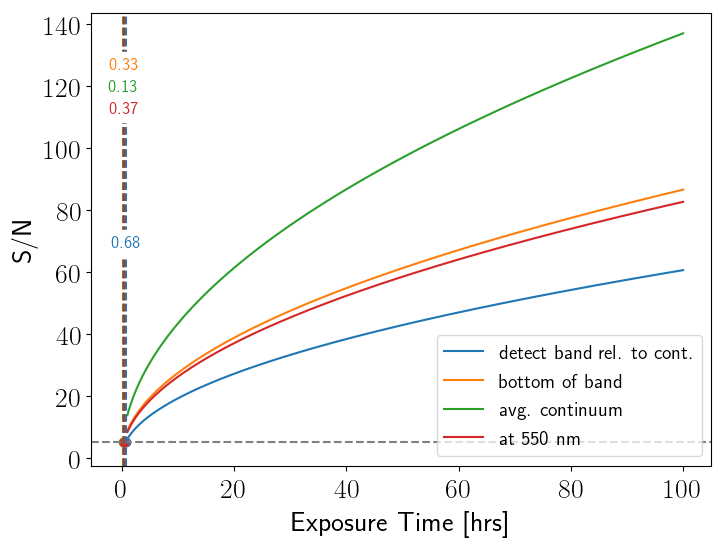

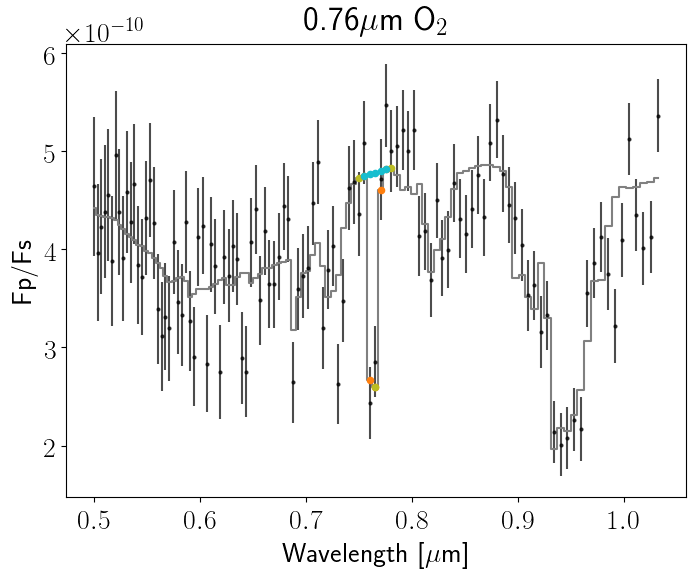

In [604]:
i = np.nanargmin(ctime_band)
print("%.2f hours to detect band with SNR = %.1f" %(ctime_band[i], wantSNR))
print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
imatch = match_stellar_type(stype[i])
a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
a_eeq = np.sqrt(lums[imatch])
print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

cn = prep_ith_star(cn, i)
etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=True, plot_spectrum=True, wantSNR=wantSNR)

ValueError: 'color' kwarg must be an mpl color spec or sequence of color specs.
For a sequence of values to be color-mapped, use the 'c' kwarg instead.

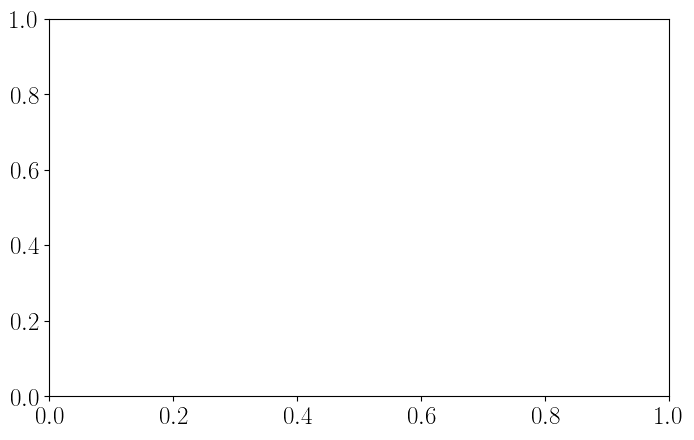

In [617]:
from jakely import colorize

colors = 

plt.scatter(ctime_fid, ctime_band, color = temps)

In [585]:
Ndraw = len(dist)      # Number of stars to calculate for
wantSNR = 5.0

cn.telescope = default_luvoir(architecture="A", channel="NIR")

np.random.seed(seed=None)

# Allocate memory for exposure times
ctime_band = np.zeros(Ndraw)
ctime_bot = np.zeros(Ndraw)
ctime_cont = np.zeros(Ndraw)
ctime_fid = np.zeros(Ndraw)
pct_obs_iwa = np.zeros(Ndraw)
lammax_obs_iwa = np.zeros(Ndraw)
    
# Randomly draw sample indices
#idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

# Order systems by "detectability"
#idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = prep_ith_star(cn, i)
    
    # Run count rates
    #etimes = determine_exposure_time(cn, [0.88, 1.0], title = "0.96$\mu$m H$_2$O", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    #etimes = determine_exposure_time(cn, [0.75, 0.78], title = "0.76$\mu$m O$_2$", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=False, plot_spectrum=False, wantSNR=wantSNR)
    
    #etime_band, etime_bot, etime_cont, etime_fid = etimes

    # Parse and distribute results
    ctime_band[i] = etimes[0]
    ctime_bot[i] = etimes[1]
    ctime_cont[i] = etimes[2]
    ctime_fid[i] = etimes[3]
    
    # Calculate percent of observable spectrum 
    pct_obs_iwa[i] = float(sum(np.isfinite(cn.Cobs))) / float(len(cn.Cobs))
    
    if pct_obs_iwa[i] > 0.0:
        lammax_obs_iwa[i] = np.max(cn.lam[np.isfinite(cn.Cobs)])
    else:
        lammax_obs_iwa[i] = np.nan
    
#print(ctime_band, ctime_bot, ctime_cont)

/Users/Jake/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


In [586]:
incomplete_vis_spectra = (pct_obs_iwa < 1.0)

print("Incomplete Spectra (%i/%i)" %(np.sum(incomplete_vis_spectra), Ndraw))
print("------------------")
for i in np.arange(Ndraw)[incomplete_vis_spectra]:
    print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
    imatch = match_stellar_type(stype[i])
    a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
    a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
    print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
    a_eeq = np.sqrt(lums[imatch])
    print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
    print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

Incomplete Spectra (17/58)
------------------
- HIP 84720, 8.80 pc, M0V 
HZ limits : 0.38 - 0.72 au
Earth-Equivalent Insolation Distance : 0.35 au
11.63% of spectrum is observable (lam max = 1.09)
- HIP 42808, 11.18 pc, K2V 
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
70.93% of spectrum is observable (lam max = 1.53)
- HIP 40693, 12.49 pc, K0V 
HZ limits : 0.76 - 1.36 au
Earth-Equivalent Insolation Distance : 0.74 au
79.07% of spectrum is observable (lam max = 1.61)
- HIP 82588, 16.74 pc, G8V 
HZ limits : 0.82 - 1.46 au
Earth-Equivalent Insolation Distance : 0.81 au
43.02% of spectrum is observable (lam max = 1.31)
- HIP 42808, 11.18 pc, K2V 
HZ limits : 0.66 - 1.19 au
Earth-Equivalent Insolation Distance : 0.63 au
70.93% of spectrum is observable (lam max = 1.53)
- HIP 57507, 17.76 pc, G5V 
HZ limits : 0.92 - 1.61 au
Earth-Equivalent Insolation Distance : 0.92 au
55.81% of spectrum is observable (lam max = 1.41)
- HIP 69972, 11.82 pc, K3V 
HZ limits : 0.6

75.15 hours to detect band with SNR = 5.0
- HIP 91772, 3.49 pc, K5 
No exact match found
Using K5V for K5
HZ limits : 0.54 - 1.01 au
Earth-Equivalent Insolation Distance : 0.52 au
100.00% of spectrum is observable (lam max = 1.81)


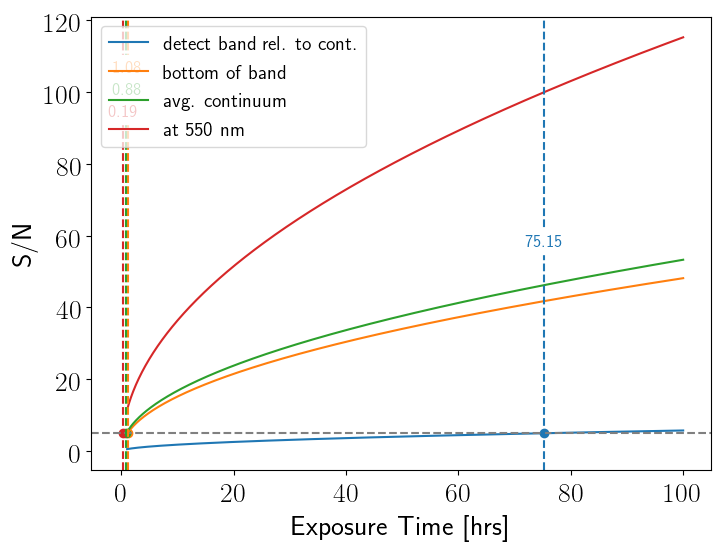

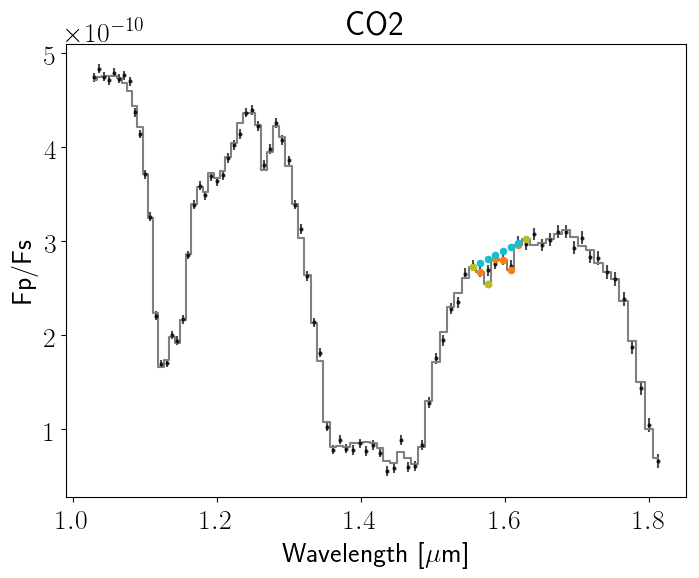

In [589]:
i = np.argmin(ctime_band)
print("%.2f hours to detect band with SNR = %.1f" %(ctime_band[i], wantSNR))
print("- HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))
imatch = match_stellar_type(stype[i])
a_in = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_inner, inner_edge))
a_out = calc_dist(lums[imatch], calc_seff(temps[imatch], S0_outer, outer_edge))
print("HZ limits : %.2f - %.2f au" %(a_in, a_out))
a_eeq = np.sqrt(lums[imatch])
print("Earth-Equivalent Insolation Distance : %.2f au" %a_eeq)
print("%.2f%% of spectrum is observable (lam max = %.2f)" %(100.*pct_obs_iwa[i], lammax_obs_iwa[i]))

cn = prep_ith_star(cn, i)
etimes = determine_exposure_time(cn, [1.55, 1.63], title = "CO2", plot_snr_curves=True, plot_spectrum=True, wantSNR=wantSNR)